# Homework for Week-4

In [1]:
## Dataset to download for week-4 homework
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv -O ../data/04_data_homework.csv

--2022-10-10 03:05:24--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘../data/04_data_homework.csv’

../data/04_data_hom 100%[===================>]  71.53K  --.-KB/s    in 0.02s   

2022-10-10 03:05:24 (3.17 MB/s) - ‘../data/04_data_homework.csv’ saved [73250/73250]



***

# Import Modules

In [2]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import KFold

# Load utilities

In [6]:
import sys 
sys.path.append('../src/')

import utilities as utils

***

# Read Data 

In [7]:
df = pd.read_csv('../data/04_data_homework.csv')
df.shape

(1319, 12)

In [5]:
df.dtypes

card            object
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [6]:
# target varirable is card
df.card.value_counts()

yes    1023
no      296
Name: card, dtype: int64

***

# Data Preparation 

In [7]:
# Map target variables yes=1 and no=0
df.card = (df.card == 'yes').astype('int')

In [8]:
df.card.value_counts()

1    1023
0     296
Name: card, dtype: int64

In [22]:
# Split dataset into 3 parts 
df_train, df_val, df_test = utils.split_datasets_602020(df, 
                                                        randstate=1, 
                                                        verbose=True)

# Prepare features and target sets
df_train, y_train = utils.dataset_into_features_and_target(df_train, target='card')
df_val, y_val     = utils.dataset_into_features_and_target(df_val, target='card')
df_test, y_test   = utils.dataset_into_features_and_target(df_test, target='card')

 Split lengths: 791 264 264
 Split %: 59.97,                       20.02,                       20.02


***

# Question 1

- ROC AUC could also be used to evaluate feature importance of numerical variables.-

In [23]:
df_train.dtypes

reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [24]:
list_numericals = utils.get_numerical_features(df_train)
list_numericals

['reports',
 'age',
 'income',
 'share',
 'expenditure',
 'dependents',
 'months',
 'majorcards',
 'active']

In [32]:
# AUC scores on numerical features 
features_q1 = ['reports', 'dependents', 'active', 'share']
auc_q1 = []

for feature in list_numericals:
    auc = roc_auc_score(y_train, df_train[feature])
    
    if auc < 0.5:
            auc = roc_auc_score(y_train, -df_train[feature])
            
    if feature in features_q1:
        auc_q1.append(auc)
            
    print(f' feature= {feature:10s} \t auc= {auc:.4f}')

 feature= reports    	 auc= 0.7167
 feature= age        	 auc= 0.5240
 feature= income     	 auc= 0.5908
 feature= share      	 auc= 0.9892
 feature= expenditure 	 auc= 0.9910
 feature= dependents 	 auc= 0.5328
 feature= months     	 auc= 0.5294
 feature= majorcards 	 auc= 0.5344
 feature= active     	 auc= 0.6043


In [33]:
np.max(auc_q1)

0.989183643423692

***

# Training the model

In [34]:
# Features to use for the model
list_features = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
list_features

['reports',
 'age',
 'income',
 'share',
 'expenditure',
 'dependents',
 'months',
 'majorcards',
 'active',
 'owner',
 'selfemp']

In [67]:
def train(df_train, y_train,C):
    
    dicts = df_train[list_features].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [36]:
dv, model = train(df_train, y_train)

***

# Question 2

- What's the AUC of this model on the validation dataset? (round to 3 digits)

In [37]:
def predict(df, dv, model):
    dicts = df[list_features].to_dict(orient='records')
    
    X = dv.transform(dicts)
    
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred

In [39]:
y_pred = predict(df_val, dv, model)

# AUC score on val_dataset
auc = roc_auc_score(y_val, y_pred)
auc

0.995171242063847

***

# Question 3
- Precision and Recall

In [45]:
thresholds = np.linspace(0.0, 1.0, 101)

scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    pred_positive = (y_pred >= t)
    pred_negative = (y_pred < t)
    
    TP = (pred_positive & actual_positive).sum()
    TN = (pred_negative & actual_negative).sum()

    FP = (pred_positive & actual_negative).sum()
    FN = (pred_negative & actual_positive).sum()

    scores.append((t, TP, FP, FN, TN))
        
columns = ['threshold', 'TP', 'FP', 'FN', 'TN']

df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,threshold,TP,FP,FN,TN
0,0.00,211,53,0,0
1,0.01,211,34,0,19
2,0.02,211,31,0,22
3,0.03,211,24,0,29
4,0.04,211,22,0,31
...,...,...,...,...,...
96,0.96,204,0,7,53
97,0.97,203,0,8,53
98,0.98,203,0,8,53
99,0.99,202,0,9,53


In [47]:
# Precision and REcall 
df_scores['Precision'] = df_scores.TP / (df_scores.FP + df_scores.TP)
df_scores['Recall'] = df_scores.TP / (df_scores.FN + df_scores.TP)
df_scores

,threshold,TP,FP,FN,TN,Precision,Recall
0,0.00,211,53,0,0,0.799242,1.000000
1,0.01,211,34,0,19,0.861224,1.000000
2,0.02,211,31,0,22,0.871901,1.000000
3,0.03,211,24,0,29,0.897872,1.000000
4,0.04,211,22,0,31,0.905579,1.000000
...,...,...,...,...,...,...,...
96,0.96,204,0,7,53,1.000000,0.966825
97,0.97,203,0,8,53,1.000000,0.962085
98,0.98,203,0,8,53,1.000000,0.962085
99,0.99,202,0,9,53,1.000000,0.957346


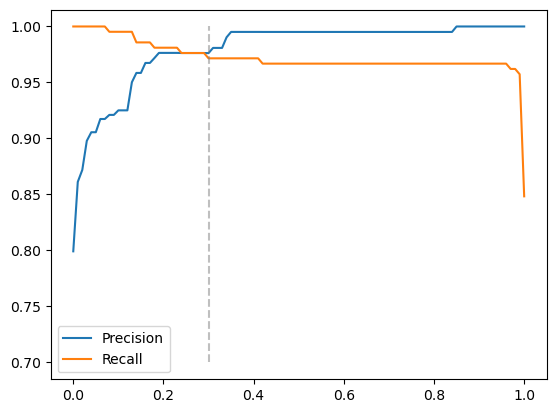

In [51]:
plt.plot(df_scores.threshold, df_scores['Precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['Recall'], label='Recall')

plt.vlines(0.3, 0.7, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()

***

# Question 4
- F1 score

In [53]:
# F1 score
df_scores['F1_score'] = 2. * (df_scores.Precision * df_scores.Recall / (df_scores.Precision + df_scores.Recall))
df_scores

,threshold,TP,FP,FN,TN,Precision,Recall,F1_score
0,0.00,211,53,0,0,0.799242,1.000000,0.888421
1,0.01,211,34,0,19,0.861224,1.000000,0.925439
2,0.02,211,31,0,22,0.871901,1.000000,0.931567
3,0.03,211,24,0,29,0.897872,1.000000,0.946188
4,0.04,211,22,0,31,0.905579,1.000000,0.950450
...,...,...,...,...,...,...,...,...
96,0.96,204,0,7,53,1.000000,0.966825,0.983133
97,0.97,203,0,8,53,1.000000,0.962085,0.980676
98,0.98,203,0,8,53,1.000000,0.962085,0.980676
99,0.99,202,0,9,53,1.000000,0.957346,0.978208


In [58]:
# Max F1 scores for thresholds
df_scores[df_scores['F1_score'] == df_scores['F1_score'].max()].threshold.values

array([0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41])

***

# Question 5
- Kfold CV 

In [65]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [62]:
from tqdm.auto import tqdm

In [71]:
nsplits = 5
target = 'card'
kfold = KFold(n_splits=nsplits, random_state=1, shuffle=True)

#for C in tqdm([0.001, 0.01, 0.1, 1.0, 10.], total=nsplits):
for C in tqdm([1.0], total=1):

    scores = [] 

    for train_idx, val_idx in kfold.split(df_train_full):

        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train[target].values
        y_val = df_val[target].values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print(f'C ={C} score_mean={np.mean(scores)*100:.3f}, score_std={np.std(scores):.3f}')


  0%|          | 0/1 [00:00<?, ?it/s]

C =1.0 score_mean=99.645, score_std=0.003


***

# Question 6
- Iterate over C values

In [72]:
nsplits = 5
target = 'card'
kfold = KFold(n_splits=nsplits, random_state=1, shuffle=True)
list_C = [0.01, 0.1, 1.0, 10.]


for C in tqdm(list_C, total=len(list_C)):

    scores = [] 

    for train_idx, val_idx in kfold.split(df_train_full):

        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train[target].values
        y_val = df_val[target].values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print(f'C ={C} score_mean={np.mean(scores)*100:.3f}, score_std={np.std(scores):.3f}')


  0%|          | 0/4 [00:00<?, ?it/s]

C =0.01 score_mean=99.188, score_std=0.006
C =0.1 score_mean=99.506, score_std=0.004
C =1.0 score_mean=99.645, score_std=0.003
C =10.0 score_mean=99.639, score_std=0.003
